<a href="https://colab.research.google.com/github/psa2001/computer_vision/blob/main/epipolar_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip 'epipolar'

In [ ]:
ls

epipolar.zip  sample_data/


In [ ]:
ls

epipolar.zip  sample_data/


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

In [ ]:
dataset_dir = Path('drive/My Drive/Elementary_Geometry')
os.chdir(dataset_dir)   

In [ ]:
ls

epipolar_task.ipynb       epipolar.zip  moto/  ransac.py  temple/
epipolar_task_mine.ipynb  functions.py  pic/   sol/


# Задание 0. Работа с камерами. (1 балл)
В этом демо вы познакомитесь с гомогенными координатами, с камерами внутренней и внешней калибровки, а также реализуете модель pinhole-камеры. Условием для сдачи этой части являеются пройденные assert-ы, работающее демо, а также ответы на вопросы.

## Задача:
Есть сцена с трехмерными точками, а также камера, с параметрами внутренней и внешней калибровки. Необходимо получить изображение, которое "видит" данная камера, т.е. проекцию трехмерных точек на плоскость изображения этой камеры.

### Небольшие пояснения:
1) Камера на трехмерной сцене изображена красной точкой, ее направление - длинной красной стрелкой, а направление "вверх" - короткой синей. 
2) Если точка оказывается за плоскостью изображения (т.е. расстояние от точки до камеры негативное), то точка рисуется в виде окружности.
3) Расстояние до точки мы отображаем с помощью размера точки. При этом точки отрисовываются в порядке убывания их расстояния от камеры (z_order), чтобы перекрытия отрисовывались корректно.

#### Замечание:
Координатная система Matplotlib предполагает, что ось Z направлена вверх, а ось Y - вправо, в то время как работая с матрицами параметров камеры, мы предполагаем, что ось Z направлена вперед, а ось Y - вправо. Поэтому, прежде чем отрисовать трехмерную сцену, мы меняем оси Y и Z местами.  
  
Еще, к сожалению, Matplotlib не умеет обновлять трехмерный график с помощью слайдеров, поэтому при изменении параметров с помощью слайдеров, меняться будет только проекция (правый график). 

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

In [ ]:
from matplotlib.widgets import Slider

class SliderUpdater:
    def __init__(self, var, ind, slider):
        self.var = var
        self.ind = ind
        self.slider = slider
    
    def __call__(self, val):
        if self.ind is None:
            self.var = self.slider.val
        else:
            self.var[self.ind] = self.slider.val

        b, dh, extrinsic_mat, intrinsic_mat = get_b()
        zorder = np.argsort(np.abs(dh[2, :]))[::-1]
        for l, pt_i, d_i, c_i in zip(l_arr[zorder], b[zorder], dh[2, :][zorder], colors[zorder]):
            l.set_sizes([100./np.abs(d_i)])
            l.set_offsets(pt_i)
            l.set_edgecolor(c_i)
            l.set_facecolor(c_i if d_i >= 0 else 'w')
        #fig.canvas.draw_idle()
    
def make_slider(pos, name, low, high, var, ind):
    ax_sl = plt.axes(pos)
    if ind is None:
        sl = Slider(ax_sl, name, low, high, valinit=var)
    else:
        sl = Slider(ax_sl, name, low, high, valinit=var[ind])
    
    sl_upd = SliderUpdater(var, ind, sl)
        
    sl.on_changed(sl_upd)
        
    return ax_sl, sl, sl_upd

Реализуйте расчет матриц внутренней и внешней калибровки в зависимости от параметров.  
  
__Важно!:__ Матрицу внешней калибровки проще задавать через положение камеры относительно мировых координат, а не исходя из того, какое преобразование мы хотим применить к мировым точкам. Эти два способа задания матрицы внешней калибровки связаны отношением обращения матрицы (чтобы это было возможно, к матрице внешней калибровки дописана дополнительная строка, чтобы матрица стала квадратной 4x4, вам не нужно этого делать, нужно просто сформировать конечную матрицу (3x4)):

In [ ]:
ls

epipolar_task.ipynb       epipolar.zip  moto/  ransac.py  temple/
epipolar_task_mine.ipynb  functions.py  pic/   sol/


![pic/cam.png](pic/cam.png)

$C$ в данном случае - местоположение камеры в мировых координатах, $R_c$ - матрица поворота, описывающая поворот камеры относительно мировых координат.

Обозначения:  
* a - точки на сцене с цветами colors
* c - местоположение камеры на сцене
* theta - углы поворота камеры вокруг осей OX, OY, OZ в радианах. Преобразование применяется в указанном порядке осей.
* e - параметры фокусного расстояния. e[2] - фокусное расстояние, а e[0] и e[1] - регулируют растяжение изображения по осям X и Y (обычно они равны и изображение получается не растянутым)
* p - смещение центра проекции по осям X и Y

Случай $shear \neq 0$ мы не рассматриваем (нас интересует случай с квадратными пикселями)

Посчитайте матрицы внетренней и внешней калибровки для камеры по заданным параметрам.  
Полезная информация:  
http://ksimek.github.io/2012/08/22/extrinsic/  
http://ksimek.github.io/2013/08/13/intrinsic/  
https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%BF%D0%BE%D0%B2%D0%BE%D1%80%D0%BE%D1%82%D0%B0

In [ ]:
def get_extrinsic_mat(c, theta):
    
    def get_rot_mat_3d(thetas):
        #get matrix R in get_rot_mat_3d
        def get_rot_mat_2d(theta):
            # your code here
            return (np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta))

        # your code here
        R = np.zeros((3, 3))
        
        R_x = np.zeros((3, 3))
        R_x[0,0] = 1
        a = np.array(get_rot_mat_2d(-theta[0]))
        a = a.reshape((2,2))
        R_x[1:,1:] = a
        R = R_x

        R_y = np.zeros((3, 3))
        R_y[1,1] = 1
        a = np.array(get_rot_mat_2d(theta[1]))
        a = a.reshape((2,2))
        R_y[::2,::2] = a
        R = np.dot(R, R_y)

        R_z = np.zeros((3, 3))
        R_z[2,2] = 1
        a = np.array(get_rot_mat_2d(-theta[2]))
        a = a.reshape((2,2))
        R_z[:2,:2] = a
        R = np.dot(R, R_z)

        return R
    
    #your code here
    R = get_rot_mat_3d(theta)
    extrinsic_mat = np.zeros((3, 4), dtype = np.float64)
    extrinsic_mat[:, : 3] = R
    extrinsic_mat[:, 3] = np.dot(R, -c)
    return extrinsic_mat


def get_intrinsic_mat(e, p):
    # your code here

    intrinsic = np.array([[e[2] / e[0] ,0 ,p[0]],
                         [0    ,e[2]/ e[1],p[1]],
                         [0    ,0    ,1]])
    return intrinsic

In [ ]:
# x,y,z coordinates
a = np.array([[0.1, -0.3, 1.3], [0., 0., 1.], [-0.1, 0.3, 0.7]])
colors = np.array(['c', 'm', 'y'])

# extrinsic mat params
c = np.array([0.2, 0.2, 0.2])
theta = np.array([0.2,0.2,0.2])

# intrinsic mat params
e = np.array([1., 1., 0.3])
p = np.array([0., 0.5])


In [ ]:
extrinsic_mat = get_extrinsic_mat(c, theta)
intrinsic_mat = get_intrinsic_mat(e, p)

In [ ]:
try:
    np.testing.assert_almost_equal(np.load("./sol/extrinsic_mat.npy"), extrinsic_mat)
    np.testing.assert_almost_equal(np.load("./sol/intrinsic_mat.npy"), intrinsic_mat)
except Exception as e:
    print("Wrong answer!")
    print(e)
else:
    print('OK!')

OK!


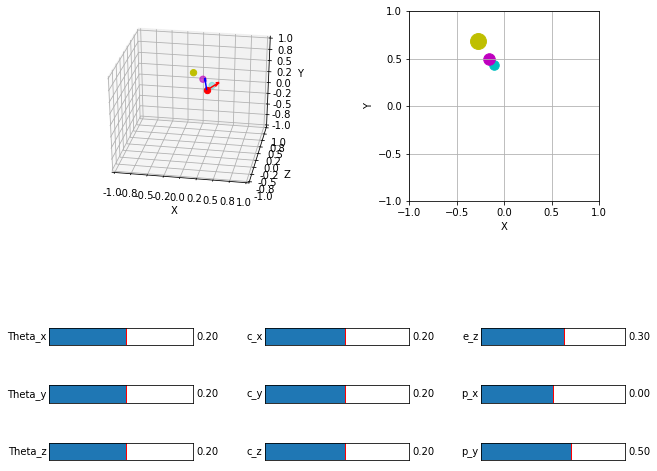

In [ ]:
# We duplicate the parameters here, just in case
# x,y,z coordinates
a = np.array([[0.1, -0.3, 1.3], [0., 0., 1.], [-0.1, 0.3, 0.7]])
colors = np.array(['c', 'm', 'y'])

# extrinsic mat params
c = np.array([0.2, 0.2, 0.2])
theta = np.array([0.2,0.2,0.2])

# intrinsic mat params
e = np.array([1., 1., 0.3])
p = np.array([0., 0.5])

def get_b():
    extrinsic_mat = get_extrinsic_mat(c, theta)
    intrinsic_mat = get_intrinsic_mat(e, p)

    cam_mat = intrinsic_mat.dot(extrinsic_mat)
    
    ah = np.vstack([a.T, np.ones(shape=a.T.shape[1])]) # homogenious a
    dh = extrinsic_mat.dot(ah)
    bh = intrinsic_mat.dot(dh) # homogenious projection on image plane
    b = np.array([bh[0, :]/bh[2, :], bh[1, :]/bh[2, :]]).T  # image coordinates

    return b, bh, extrinsic_mat, intrinsic_mat

b, dh, extrinsic_mat, intrinsic_mat = get_b()

fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.55)
ax2d = fig.add_subplot(1, 2, 2)

zorder = np.argsort(np.abs(dh[2, :]))[::-1]
l_arr = [None for _ in range(b.shape[0])]
for z_i, pt_i, d_i, c_i in zip(zorder, b[zorder], dh[2, :][zorder], colors[zorder]):
    l = ax2d.scatter(pt_i[0], pt_i[1])
    l.set_sizes([100./np.abs(d_i)])
    l.set_edgecolor(c_i)
    l.set_facecolor(c_i if d_i >= 0 else 'w')
    l_arr[z_i] = l
l_arr = np.array(l_arr)

ax2d.set_xlim(-1., 1.)
ax2d.set_ylim(-1., 1.)
ax2d.grid(True)
ax2d.set_xticks(np.linspace(-1.0, 1.0, 5))
ax2d.set_yticks(np.linspace(-1.0, 1.0, 5))
ax2d.set_xlabel('X')
ax2d.set_ylabel('Y')
ax2d.set_aspect(1)

L = []
L += make_slider([0.10, 0.3, 0.2, 0.03], 'Theta_x', -np.pi, np.pi, theta, 0)
L += make_slider([0.10, 0.2, 0.2, 0.03], 'Theta_y', -np.pi, np.pi, theta, 1)
L += make_slider([0.10, 0.1, 0.2, 0.03], 'Theta_z', -np.pi, np.pi, theta, 2)
L += make_slider([0.4, 0.3, 0.2, 0.03], 'c_x', -2, 2, c, 0)
L += make_slider([0.4, 0.2, 0.2, 0.03], 'c_y', -2, 2, c, 1)
L += make_slider([0.4, 0.1, 0.2, 0.03], 'c_z', -2, 2, c, 2)
L += make_slider([0.7, 0.3, 0.2, 0.03], 'e_z', -2, 2, e, 2)
L += make_slider([0.7, 0.2, 0.2, 0.03], 'p_x', -2, 2, p, 0)
L += make_slider([0.7, 0.1, 0.2, 0.03], 'p_y', -2, 2, p, 1)


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(azim=-80)

# x,z,y coordinates, because mpl uses coordinate system where Y axis is directed forward, instead of up

ax.scatter(a[:, 0], a[:, 2], a[:, 1], zdir='z', s=40, c=colors, depthshade=True)
ax.scatter(*-extrinsic_mat[:, -1][[0, 2, 1]], zdir='z', s=40, c='r', depthshade=True)

ax.quiver(*np.hstack([-extrinsic_mat[:, -1][[0, 2, 1]] , extrinsic_mat[2, :-1][[0, 2, 1]]/2 ]), color='r')
ax.quiver(*np.hstack([-extrinsic_mat[:, -1][[0, 2, 1]] , extrinsic_mat[1, :-1][[0, 2, 1]]/4 ]), color='b')

ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

# Here we assign the right labels to axes
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Посмотрите что будет происходить, если параметр e_z (фокусное расстояние) оказывается отрицательным. Почему так происходит?

*__Ответ*:__
изображение будет перевёрнуто горизонтально и вертикально;Проекция будет на заднюю стенку вверх ногами, некий эквивалент камеры-обскура.

# Задание 1. Эпиполярная геометрия. (3 балла)
В данной части вы познакомитесь с эпиполярной геометрией, фундаментальной и существенной (essential) матрицами, а также триангуляцией точек. Условием для сдачи этой части являеются пройденные assert-ы, визуализированное трехмерное облако точек, а также ответы на вопросы.

## Задача:
Дана стереопара, т.е. изображения с двух близко расположенных камер, а также ключевые точки на изображениях, их SIFT-декрипторы, а также соответствие между точками. Необходимо постоить фундаментальную матрицу и существенную матрицу для этих точек.



## Описание задания

Эпиполярная геометрия - геометрия стереовидения. Описывает отношения между точкой и ее двумя проекциями на плоскость, то есть отношения между координатами на двух изображениях одной физической точки. Пара изображений одной сцены, снятых с разных ракурсов, называется стереопарой.

На графике ниже $x$ и $x'$ являются проекциями физической точки $X$ на плоскости изображений стереопары. $С$ и $С'$ - центры камер. Плоскость, проходящую через точки $С$, $С'$ и $X$ называют эпиполярной плоскостью, прямые $l$, $l'$, в которых эпиполярная плоскость пересекает проскости изображений - эпиполярными линиями, а точки $e$ и $e'$, в которых отрезок $СС'$ пересекает плоскости изображений - эпиполярными точками, или эпиполями. Все эпиполярные линии пересекаются в точках $e$ и $e'$ на первом и втором изображении соответственно. Множество эпиполярных плоскостей представляет собой пучок, пересекающийся по отрезку $СС'$.

Ограничение на положение соответствующих точек $x$ и $x'$, вытекающей из эпиполярной геометрии, можно сформулировать следующим образом: точка $x'$, соответствующая $x$, должна лежать на эпиполярной линии $l'$, соответствующей $x$. Это условие называется эпиполярным ограничением.

Фундаментальной матрицей $F$ называется матрица, которая для любых соответствующих точек удовлетворяет уравнению:

$$xFx' = 0$$


и по сути своей содержит всю необходимую информацию о соответствии между точками двух изображений.  


![pic/graph.png](pic/graph.png)

In [ ]:
import numpy as np
import itertools
import skimage.io as io

Прочтем изображения, ключевые точки с дескрипторами SIFT, а также матрицы калибровки. Нам понадобится только матрица калибровки одной из камер, потому что эти матрицы отличаются только положением центра проекции (principal point), а этот фактор будет автоматически учтен при восстановлении матриц внешней калибровки. 

In [ ]:
ls

sample_data/


In [ ]:
im1 = io.imread('moto/im0.png')
im2 = io.imread('moto/im1.png')
l1, d1 = np.load("moto/im0_feat.npz").values()
l2, d2 = np.load("moto/im1_feat.npz").values()
matches = np.load("moto/matches.npz")["matches"]

with open('moto/calib.txt', 'r') as f:
    camL = f.readline()
    camR = f.readline()
    str2mat = lambda s: np.array(list(map(float, s.replace(';', '')[6:-2].split()))).reshape(3,3)
    camL = str2mat(camL)
    camR = str2mat(camR)
    K = camR
    inv_K = np.linalg.inv(K)
    

Визуализируем стереопару

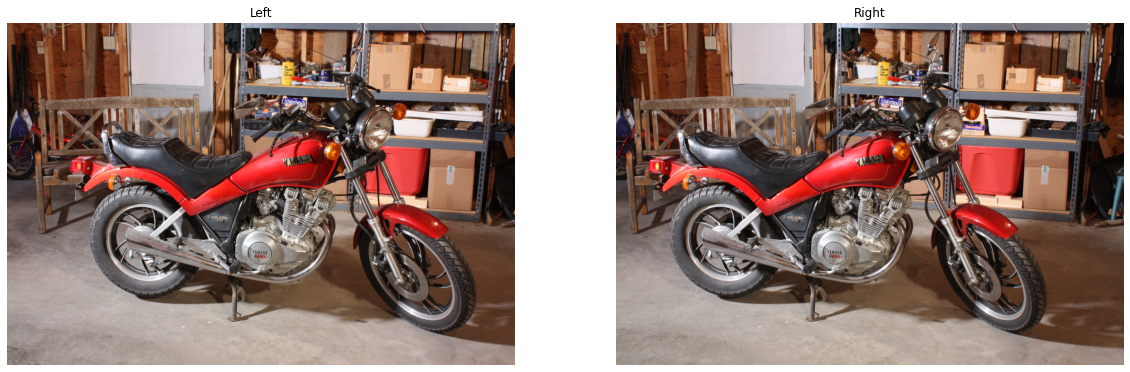

In [ ]:
f, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[0].axis('off')
ax[0].set_title('Left')
ax[1].axis('off')
ax[1].set_title('Right')
plt.show()

Заметим, что считанная матрица с параметрами внутренней калибровки подразумевает модель pinhole camera. На практике, конечно, фотографии скорее всего были сделаны с помощью некоторой зеркальной камеры, не лишенной недостатков. Реальные камеры, в силу наличия системы линз, при съемке вносят в изображение искажения, и поэтому описываются более сложными моделями. Но на практике, проще применить к изображению преобразование, нейтрализующее искажения камеры, и дальше предполагать, что оно было получено с помощью pinhole camera.  

В папке __moto/imperfect__ находятся изображения до устранения искажений, и вы можете сравнить их со считанными. Вы увидете, что реальные изображения немного "выпуклые", это называется lens distortion.

Визуализируем ключевые точки SIFT, а также их соответствия.

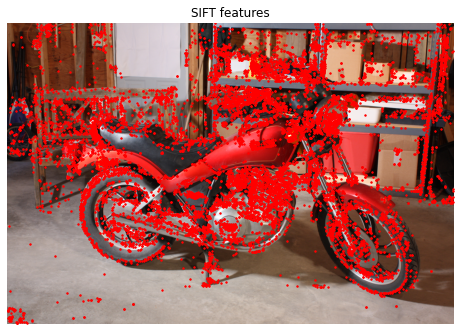

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(im1)
plt.axis('off')

plt.scatter(l1[:, 1], l1[:, 0], c='r', s=2)
plt.title("SIFT features")
plt.show()

In [ ]:
from skimage.feature import plot_matches

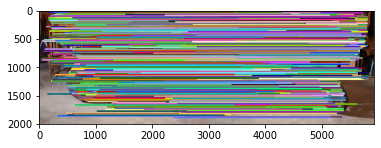

In [ ]:
f, ax = plt.subplots()
plot_matches(ax, im1, im2, l1, l2, np.vstack([matches.nonzero(), matches[matches!=0]]).T, only_matches=True)

Отсеим ключевые точки, не имеющие пары, и преобразуем оставшиеся ключевые точки в гомогенные координаты. Далее применим к ним преобразование, устраняющее действие матрицы внутренней калибровки. Это позволит нам найти сразу существенную матрицу, а не просто фундаментальную, применяя тот же самый алгоритм, но к преобразованным точкам.

Здесь и далее мы будем хранить точки по столбцам.

In [ ]:
def make_homog(points):
    """ Convert a set of points (dim*n array) to 
        homogeneous coordinates. """
        
    return np.vstack((points, np.ones((1,points.shape[1])))) 

In [ ]:
ndx = matches.nonzero()[0]
# make homogeneous and transform with inv(K)
x1 = make_homog(l1[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = make_homog(l2[ndx2,:2].T)
x1n = np.dot(inv_K,x1)
x2n = np.dot(inv_K,x2)


### Расчет фундаментальной матрицы 

1. Матрица $F$ для каждой пары соответствующих точек $(u1_i, u2_i)$ удовлетворяет уравнению

    $$u1_i * F * u2_i = 0$$

    Поскольку матрица $F$ имеет размерность 3х3, то данное уравнение имеет 8 степеней свободы. Следовательно, для получения однозначного решения требуется не менее 8-ми ранее размеченных соответствующих точек стереопары. Получаем систему из 8-ми уравнений $A*f = 0$. Решив ее методом наименьших квадратов, получаем матрицу $F$.
    
    Подробнее о решении полученной системы уравнений можно узнать [тут](http://legacydirs.umiacs.umd.edu/~ramani/cmsc828d/lecture27.pdf).

<img src="pic/pic3.png" width="45%"/>
<img src="pic/pic4.png" width="45%"/>

2. Далее для понижения ранга полученной матрицы $F$ будем использовать сингулярное разложение матрицы. 

     $$u, s, vh = SVD(F)$$
    
    Для этого достаточно получить разложение матрицы $F$, в диагональной матрице сингулярных чисел $s$ обнулить последнюю строку и декомпозировать матрицу обратно. Получена фундаментальная матрица $F$. 

<img src="pic/pic5.png" width="45%"/>

Реализуйте расчет фундаментальной матрицы с помощью нормализованного 8-ми точечного алгоритма. Много дополнительной полезной информации можно найти здесь: https://slideplayer.com/slide/3275895/

__life hack #1__: Решение системы $Ax=0$ методом наименьших квадратов может быть легко получено с помощью SVD-разложения: достаточно взять сингулярный вектор SVD-разложения матрицы A, соответствующий минимальному сингулярному значению.  

__life hack #2__: Для того, чтобы результат работы вашего алгоритма получался точным, исходные координаты необходимо нормализовать. Дело в том, что исходные координаты имеют порядок $~10^3 - 10^4$ (потому что исходные изображения в высоком разрешении). Как известно, численные алгоритмы зачастую работают неустойчиво с очень большими или очень малыми числами, поэтому прежде чем применять 8-ми точечный алгоритм, мы нормализуем исходные координаты в функции compute_fundamental_normalized.

In [ ]:
def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each element in the A matrix below is constructed as
        [x'*x, x'*y, x', 
        y'*x, y'*y, y', 
        x, y, 1] """
    
    A = np.zeros((x1.shape[1], 3, 3))
    A = np.repeat(x1.T, 3, 1) * np.tile(x2.T, 3)

    """
    for i in range(x1.shape[1]):
      A[i] = np.array([x1[0,i]*x2[0,i], x2[0,i] * x1[1, i], x2[0, i], 
                       x2[1,i] * x1[0, i], x2[1,i] * x1[1, i], x2[1,i],
                       x1[0, i], x1[1, i], 1]).reshape((3, 3))

    print(A.shape)
    """
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    
    U,S,V = np.linalg.svd(F)
    digonalka = np.zeros((3, 3))
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    return F

def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the normalized 8 point algorithm. """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1, 0, -S1*mean_1[0]], 
                   [0, S1, -S1*mean_1[1]], 
                   [0, 0, 1]
                  ])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2*mean_2[0]], 
                   [0, S2, -S2*mean_2[1]], 
                   [0, 0, 1]
                  ])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)
    F = F / F[2,2]

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

Протестируем алгоритм на первых 8-ми точках

In [ ]:
F = compute_fundamental_normalized(x1n[:, :8], x2n[:, :8])

In [ ]:
try:
    np.testing.assert_almost_equal(np.load("./sol/F.npy"), F)
except Exception as e:
    print("Wrong answer!")
    print(e)
else:
    print('OK!')

OK!


Далее мы будем искать наилучшую существенную матрицу с помощью RANSAC и только что реализованного нормализованного 8ми точечного алгоритма.

Реализуйте методы fit и get_error класса RansacModel.  
На каждой итерации Ransac будет перемешивать данные, генерировать гипотезу о F с помощью метода fit, а затем оценивать ее с помощью метода get_error.

fit должен принимать массив data, в котором сконкатенированы массивы точек с двух камер. Т.е. data.shape = (6, N). Так как мы используем 8-ми точечный алгоритм, то необходимо взять только первые 8 точек. В дальнейшем RANSAC будет на каждой итерации перемешивать точки и вызывать fit, поэтому каждый раз первые 8 точек будут различными.  

В get_error реализуйте расчет метрики Сэмпсона для __всех__ точек в data (не только для первых 8):  

$$d_1=F x_1$$
$$d_2=F^T x_2$$
$$Dist(x_1, x_2, F) = \frac{{\operatorname{diag}\left({x_1}^T F x_2\right)}^2}{{d_1[0]}^2+{d_1[1]}^2+{d_2[0]}^2+{d_2[1]}^2}$$

Метрика Сэмпсона показывает насколько хорошо данная матрица F подходит для данного набора точек $x_1$ и $x_2$. Более подробно про метрики здесь: https://arxiv.org/pdf/1706.07886.pdf (Fundamental Matrix Estimation: A Study of Error Criteria)

In [ ]:
class RansacModel(object):
    """ Class for fundmental matrix fit with ransac.py from
        http://www.scipy.org/Cookbook/RANSAC"""
    
    def __init__(self,debug=False):
        self.debug = debug
    
    def fit(self,data):
        """ Estimate fundamental matrix using eight 
            selected correspondences. """
        cur = data.T
        x1 = cur[:3, :8]
        x2 = cur[3:, :8]
        return compute_fundamental_normalized(x1, x2)
        
    
    def get_error(self,data,F):
        """ Compute x^T F x for all correspondences, 
            return error for each transformed point. """
        #your code here
        cur = data.T
        x1 = cur[:3,:]
        x2 = cur[3:6, :]
        d1 = np.dot(F, x1)
        d2 = np.dot(F.T, x2)
        chis = np.dot(np.dot(x1.T, F), x2) 
        diag_chis = np.diag(chis) ** 2 
        znam = d1[0] * d1[0] + d1[1] * d1[1] + d2[0] * d2[0] + d2[1] *d2[1]
        return diag_chis / znam

In [ ]:
model = RansacModel()

In [ ]:
data = np.vstack((x1n, x2n))
F_est = model.fit(data.T)
err_est = model.get_error(data.T, F)

In [ ]:
try:
    np.testing.assert_almost_equal(np.load("./sol/F_est.npy"), F_est)
    np.testing.assert_almost_equal(np.load("./sol/err_est.npy"), err_est)
except Exception as e:
    print("Wrong answer!")
    print(e)
else:
    print('OK!')

OK!


In [ ]:
from functions import F_from_ransac, compute_P_from_essential, triangulate

Запустим RANSAC для поиска наилучшей существенной матрицы.

In [ ]:
# estimate E with RANSAC
model = RansacModel()
E,inliers = F_from_ransac(x1n,x2n, model, maxiter=100)
F = inv_K.T.dot(E).dot(inv_K)

Посмотрим на элементы диагональной матрицы в SVD-разложении фундаментальной матрицы и существенной матрицы. Обратите внимание, что у существенной матрицы диагональные элементы почти одинаковые. Почему?

__Ответ:__ В результате SVD разложения можно получить translation и rotation. А так как камеры очень близки, то показатели, по которым будут находиться искомые характеристики близки.

In [ ]:
print(np.linalg.svd(F)[1].round(3), np.linalg.svd(E)[1].round(3))

[1.726 0.516 0.   ] [3740.037 3727.201    0.   ]


Получим матрицу внешней калибровки правой камеры по существенной матрице, предполагая, что левая камера находится в центре сцены и все углы поворота нулевые.  
Если бы у нас была только фундаментальная матрица (если бы у нас не было матрицы внутренних параметров), то мы не смогли бы восстановить камеру внешней калибровки с достаточной точностью (мы смогли бы сделать это с точностью до произвольного перспективного перобразования).

In [ ]:
# compute camera matrices (P2 will be list of four solutions)
P1 = np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.]])
P2 = compute_P_from_essential(E)

Матрица внешней калибровки восстанавливается с точностью до обмена позиций камер и поворота одной из камер на 180 градусов относительно линии, соединяющей камеры (baseline). Вот пример четырех возможных расположений камер:

<img src="pic/pic2.png" width="45%"/>

__Поэтому, выберем такую матрицу, чтобы перед обеими камерами было максимальное число точек.__

In [ ]:
ind = 0
maxres = 0
for i in range(4):
    # triangulate inliers and compute depth for each camera
    X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[i])
    dist1 = np.dot(P1,X)[2]
    dist2 = np.dot(P2[i],X)[2]
    if sum(dist1>0)+sum(dist2>0) > maxres:
        maxres = sum(dist1>0)+sum(dist2>0)
        ind = i

# triangulate inliers and remove points not in front of both cameras
X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[ind])
dist1 = np.dot(P1,X)[2]
dist2 = np.dot(P2[ind],X)[2]
infront = (dist1>0) & (dist2>0)
X = X[:,infront]

Построим облако точек.

In [ ]:
im1_pts = x1[:,inliers][:, infront][[0, 1], :]
im2_pts = x2[:,inliers][:, infront][[0, 1], :]

im1_colors = im1[[im1_pts[0, :].astype(int)], [im1_pts[1, :].astype(int)]][0]/255.
im2_colors = im2[[im1_pts[0, :].astype(int)], [im2_pts[1, :].astype(int)]][0]/255.
im1_colors.shape

(2895, 3)

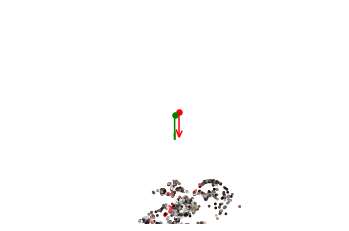

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# BTW: the result might appear mirrored or rotated. Fix mpl axes in this case
ax.scatter(X[0],X[1],X[2],'k.', depthshade=False, c=im1_colors, s=3)

ax.scatter(*P1[:, -1], c='r', s=30)
ax.scatter(*P2[ind][:, -1], c='g', s=30)
ax.quiver(*np.hstack([P1[:, -1]     , P1[2, :-1]     *5]), color='r')
ax.quiver(*np.hstack([P2[ind][:, -1], P2[ind][2, :-1]*5]), color='g')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(10, -10)

plt.axis('off')
plt.show()

__Ожидаемый результат__ (красная и зеленая точки со стрелками обозначают камеры):

<img src="pic/triangulated.png" width="60%"/>


Сделайте выводы о качестве. Почему объекты вблизи получились лучше, чем объекты на заднем плане?

__Ответ:__
они не перекрываются;меньше изменений в переднем плане;больше сопоставимых точек на переднем плане;

Сделаем "репроекцию", т.е. спроецируем восстановленные трехмерные точки на плоскости изображений.

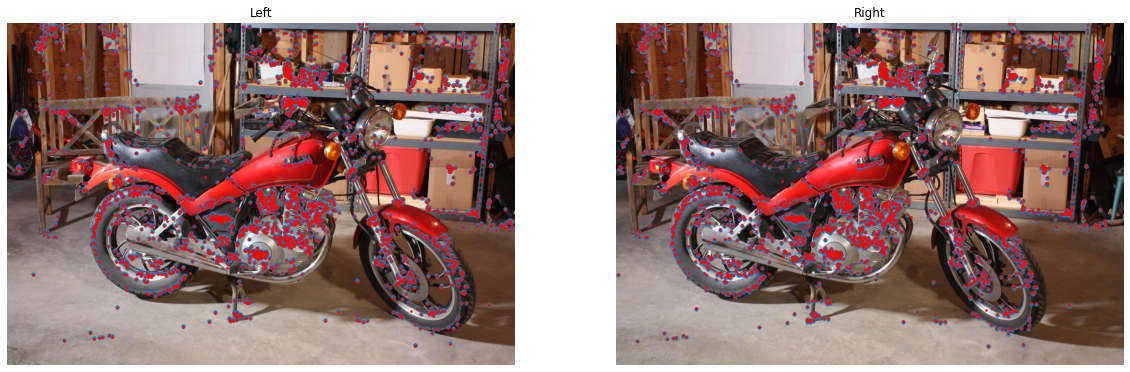

In [ ]:
# project 3D points
x1p = np.dot(P1,X)
x1p /= x1p[2]
x2p = np.dot(P2[ind],X)
x2p /= x2p[2]
# reverse K normalization
x1p = np.dot(K, x1p)
x2p = np.dot(K, x2p)
f, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].imshow(im1)
ax[1].imshow(im2)

size=10
ax[0].scatter(x1p[1],x1p[0],marker='o', s=size)
ax[0].scatter(x1[1],x1[0],marker='.', c='r', s=size)
ax[1].scatter(x2p[1],x2p[0],marker='o', s=size)
ax[1].scatter(x2[1],x2[0],marker='.', c='r', s=size)
ax[0].axis('off')
ax[0].set_title('Left')
ax[1].axis('off')
ax[1].set_title('Right')
plt.show()

Несовпадение исходных точек и "репроецированных" называется ошибкой репроекции. Почему качество репроекции отличное, но облако точек все равно далеко не идеальное (объекты на заднем плане расположены явно дальше, чем должны быть)?

__Ответ:__
Причина в том,что репроекция рассматривает точки,уже спроецированные на плоскость картинки.

Имея не два снимка некоторого объекта/сцены, а большее количество, можно применять технику bundle adjustment. Эта техника заключается в итеративном построении облака точек по многим кадрам и минимизацией ошибки репроекции. С помощью этой техники можно получать очень точные трехмерные модели сложных сцен.

Также, полученное облако точек является достаточно разреженным. Существуют методы получения плотного облака точек с помощью карт глубины, что позволяет получать существенно более качественные трехмерные модели сцен.

# Задание 3. Эпиполярные линии. (1 балл)

В данном задании вам необходимо вычислить и визуализировать эпиполярные линии. Условием для сдачи этой части являеются пройденные assert-ы, визуализации эпиполярных линий, а также ответы на вопросы.

Картинка для напоминания:
![pic/graph.png](pic/graph.png)

1. Имея матрицу $F$, вычислите эпиполярные линии
    
    $$ l1_i = F' * u2_i $$
    $$ l2_i = F * u1_i $$
    
    где $F'$ - $F$ транспонированная;  $l1_i$ - эпиполярная линия, представленная вектором $(A, B, C)$ уравнения прямой $Ax + By + C = 0$


In [ ]:
def get_epipolar_lines(u1, u2, F):
    # your code here
    el2 = np.dot(F, u1.T)
    el1 = np.dot(F.T, u2.T)
    return el1.T, el2.T

In [ ]:
from PIL import Image, ImageDraw

def draw_line(line, ax, size, fill=128, width=3):
    
    x1, x2 = [int(np.round((-line[2]-line[1]*y)/line[0])) for y in [0, size[1]-1]]
    y1, y2 = [int(np.round((-line[2]-line[0]*x)/line[1])) for x in [0, size[0]-1]]

    points = []
    if x1 >= 0 and x1 < size[0]:
        points.append((x1, 0))
        
    if x2 >= 0 and x2 < size[0]:
        points.append((x2, size[1]-1))
        
    if y1 >= 0 and y1 < size[1]:
        points.append((0, y1))
      
    if y2 >= 0 and y2 < size[1]:
        points.append((size[0], y2))
        
    if (len(points) >= 2):
        points = np.vstack(points)
        ax.plot(points[:, 0], points[:, 1], c=fill)
        

def draw_epipolar_lines_and_points(im1, im2, u1, u2, l1, l2, ax1, ax2):
    
    r = 9
    w = 8
    
    ax1.imshow(im1)
    ax2.imshow(im2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Left')
    ax2.set_title('Right')

    #Maroon, Aqua, Teal

    colors = ['red', 'blue', 'fuchsia', 'aqua', 'yellow', 'magenta', 'cyan', 'white', 'purple', 'navy', 'lime']
    colors = [colors[i%len(colors)] for i in range(u1.shape[0])]

    for i in range(l1.shape[0]):
        
        color = colors[i%len(colors)]
        
        draw_line(l1[i], ax1, im1.size, fill=color, width=w)
        ax1.scatter(u1[:, 1], u1[:, 0], c=colors, s=r)
        
        draw_line(l2[i], ax2, im2.size, fill=color, width=w)
        ax2.scatter(u2[:, 1], u2[:, 0], c=colors, s=r)

Пересчитаем фундаментальную матрицу еще раз, выставив np.random.seed(1), чтобы результат можно было однозначно сравнить с эталонным. (на всякий случай, версия numpy, на которой тестировался код: 1.16.4, но крайне вероятно, что код будет работать на одинаково независимо от версии).

In [ ]:
np.random.seed(1)

model = RansacModel()
E,inliers = F_from_ransac(x1n,x2n, model, maxiter=100)
F = inv_K.T.dot(E).dot(inv_K)

ridx = np.random.randint(0, x1.shape[1], size=20)
u1 = make_homog(x1.T)[ridx, :]
u2 = make_homog(x2.T)[ridx, :]


In [ ]:
u1.shape, u2.shape, F.shape

((20, 3), (20, 3), (3, 3))

In [ ]:
el1, el2 = get_epipolar_lines(u1, u2, F)
print(el1.shape)
# you might need to do this
el1 = el1[:, [1,0,2]]
el2 = el2[:, [1,0,2]]

(20, 3)


In [ ]:
try:
    np.testing.assert_almost_equal(np.load("./sol/el1.npy"), el1)
    np.testing.assert_almost_equal(np.load("./sol/el2.npy"), el2)
except Exception as e:
    print("Wrong answer!")
    print(e)
else:
    print('OK!')

OK!


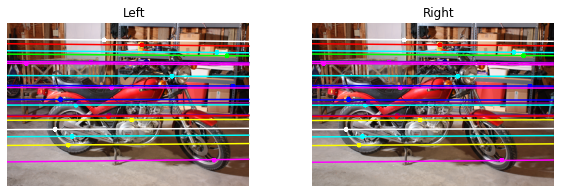

In [ ]:
img1 = 'moto/im0.png'
img2 = 'moto/im1.png'

img1 = Image.open(open(img1, 'rb'))
img2 = Image.open(open(img2, 'rb'))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
draw_epipolar_lines_and_points(img1, img2, u1, u2, el1, el2, ax1, ax2)
plt.show()

Видно, что эпиполярные линии получились почти параллельны друг другу. Это значит, что их точка пересечения (эпиполь) находится бесконечно далеко.   
Это произошло, потому что исходные фотографии - это стереопара. Вторая камера как бы получена параллельным переносом первой камеры, что соответствует простому смещению центра проекции (principal point).  
Если бы это было не так, например, если бы вторая камера была повернута относительно первой, то эпиполярные линии не были бы параллельны друг другу.   
Вот пример такой ситуации:

Точки здесь размечены вручную, матрицы внутренней калибровки для расчета эпиполярных линий не требуются.

In [ ]:
im1 = io.imread('temple/1.jpg')
im2 = io.imread('temple/2.jpg')
x1 = np.load('temple/x1.npy')
x2 = np.load('temple/x2.npy')

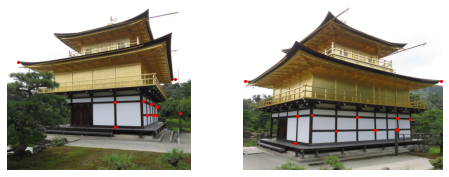

In [ ]:
f, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].scatter(x1[1, :], x1[0, :], c='r', s=4)
ax[1].scatter(x2[1, :], x2[0, :], c='r', s=4)
plt.show()

In [ ]:
F = compute_fundamental_normalized(x1, x2)

In [ ]:
u1 = x1.T
u2 = x2.T

In [ ]:
el1, el2 = get_epipolar_lines(u1, u2, F.T)

# you might need to do this
el1 = el1[:, [1,0,2]]
el2 = el2[:, [1,0,2]]

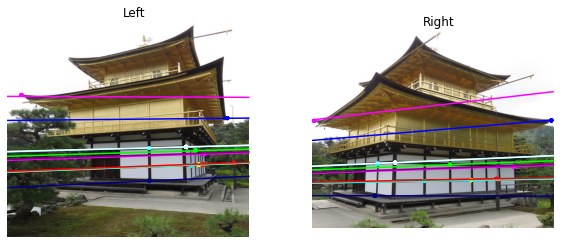

In [ ]:
img1 = 'temple/1.jpg'
img2 = 'temple/2.jpg'

img1 = Image.open(open(img1, 'rb'))
img2 = Image.open(open(img2, 'rb'))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
draw_epipolar_lines_and_points(img1, img2, u1, u2, el1, el2, ax1, ax2)
plt.show()

Как вы можете заметить, эпиполярные линии не параллельны друг другу и пересекаются в конечной точке, находящейся между камерами. Когда такое происходит в общем случае?

__Ответ:__
Есть некое значимое смещение камеры в пространстве.Ещё лучше линии от камер до изображений не параллельны. То есть можно считать,что камера снимает с разнывх ракурсов.

Подробнее об эпиполярной геометрии
http://masters.donntu.org/2012/iii/chigarev/library/article2.htm

Больше датасетов можно найти тут: http://vision.middlebury.edu/stereo/data/

Много полезного http://www.cs.toronto.edu/~jepson/csc420/notes/epiPolarGeom.pdf

При подготовке этого задания автор пользовался книгами:
* "Multiple view geometry in computer vision" by Richard Hartley
* "Programming Computer Vision with Python" by Jan Erik Solem